In [111]:
import pybaseball
import numpy as np # library for numerical computations (vectors, matrices, tensors)
import numpy.testing as np_testing # for tests
import matplotlib.pyplot as plt # library providing tools for plotting data
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans # library for K-Means clustering
from sklearn import metrics # library providing score functions, performance metrics and pairwise metrics and distance computations
from sklearn.metrics import mean_squared_error, confusion_matrix as calculate_confusion_matrix
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D # library for 3D axes object
from seaborn import heatmap
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [112]:
data = pybaseball.statcast(start_dt="2022-05-07", end_dt="2022-11-05")

This is a large query, it may take a moment to complete


100%|██████████| 183/183 [00:30<00:00,  5.94it/s]


In [113]:
data_small = data.loc[data['game_type'] == 'R', ['pitch_type', 'release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z']].reset_index(False)
data_small = data_small.drop(columns=["index"])
data_small = data_small.dropna()

In [114]:
def remove_rows_by_label(dataframe, label_to_remove):
    # Use boolean indexing to filter rows based on the label to remove
    filtered_df = dataframe[dataframe['pitch_type'] != label_to_remove]
    return filtered_df
def balance_dataframe(df, label_column):
    # Determine the minimum number of datapoints among labels
    min_count = df[label_column].value_counts().min()
    
    # Create an empty DataFrame to store balanced data
    balanced_df = pd.DataFrame(columns=df.columns)
    
    # Undersample each label to match the minimum count
    for label in df[label_column].unique():
        label_data = df[df[label_column] == label]
        label_data = label_data.sample(min_count, random_state=42)
        balanced_df = pd.concat([balanced_df, label_data], ignore_index=True)
    
    return balanced_df
def z_score_normalize_dataframe(df, label_column, value_column):
    # Group the DataFrame by the label column
    grouped = df.groupby(label_column)
    
    # Create an empty DataFrame to store the z-score normalized data
    normalized_df = pd.DataFrame(columns=[label_column, value_column])
    
    # Initialize the StandardScaler
    scaler = StandardScaler()
    
    # Iterate through each group, normalize the values, and concatenate to the result
    for label, group in grouped:
        group[value_column] = scaler.fit_transform(group[[value_column]])
        normalized_df = pd.concat([normalized_df, group], ignore_index=True)
    
    return normalized_df
def count_data_points_per_label(dataframe):
    # Use the 'groupby' function to group by the 'Label' column and count the occurrences
    label_counts = dataframe['pitch_type'].value_counts().reset_index()
    label_counts.columns = ['pitch_type', 'Count']
    
    # Sort the result by counts in descending order
    label_counts = label_counts.sort_values(by='Count', ascending=False)
    
    # Convert the result to a list of dictionaries
    label_counts_list = label_counts.to_dict('records')
    
    return label_counts_list

In [115]:
remove_types = ['KN', 'PO', 'CS', 'EP', 'FA', 'SV', 'FS']
filtered_data_small = data_small
for label in remove_types:
    filtered_data_small = remove_rows_by_label(filtered_data_small, label)
balanced_data = balance_dataframe(filtered_data_small, 'pitch_type')
#print(count_data_points_per_label(balanced_data))
features = ['pfx_z', 'pfx_x', 'spin_axis', 'release_spin_rate','release_speed']
normalized_data = balanced_data
for value in features:
    normalized_data = z_score_normalize_dataframe(normalized_data, 'pitch_type', value)
print(normalized_data)

       pitch_type release_speed release_spin_rate spin_axis     pfx_x  \
0              CH      0.134963         -0.280901  0.530367 -0.464673   
1              CH     -0.010955          0.870027  0.513315 -0.670695   
2              CH     -1.382588         -1.332896  0.428055 -0.773705   
3              CH     -0.331976          0.170896  0.734992 -0.808042   
4              CH      0.922923          0.220363  1.195397 -0.747952   
...           ...           ...               ...       ...       ...   
103931         ST     -0.725252         -2.175252  1.950297 -1.534262   
103932         ST      1.502899          1.681001 -0.372774  0.225529   
103933         ST      0.166009          0.557044  1.809504 -1.382402   
103934         ST      0.420655         -1.535678  -0.47334   0.35059   
103935         ST      0.166009          1.981976  1.779335 -1.918379   

           pfx_z  
0      -0.657824  
1       0.664356  
2       0.766062  
3       0.842342  
4      -1.776591  
...      

In [116]:
validation_size = 0.30  # 30% in total for validation (15%) and testing (15%)
testing_size = 0.70  # 70% for testing
validation_data, training_data = train_test_split(normalized_data, test_size=testing_size, random_state=42)
validation_data, testing_data =  train_test_split(validation_data, test_size=0.5, random_state=42)

In [117]:
y_val = validation_data["pitch_type"]
X_val = validation_data.drop(columns=["pitch_type"])
y = training_data["pitch_type"]
X = training_data.drop(columns=["pitch_type"])
y_test = testing_data["pitch_type"]
X_test = testing_data.drop(columns=["pitch_type"])
X_val1 = X_val.to_numpy()
y_val1 = y_val.to_numpy()
X1 = X.to_numpy()
y1 = y.to_numpy()
X_test1 = X_test.to_numpy()
y_test1 = y_test.to_numpy()

In [118]:
'''hidden_layer_sizes = [(5,), (25,), (5, 5), (25, 25)]
param_grid = {'hidden_layer_sizes': hidden_layer_sizes}
mlp = MLPClassifier(max_iter=1000)
randomized_cv = RandomizedSearchCV(mlp, param_grid, n_iter=10, scoring='accuracy')
randomized_cv.fit(X_val1, y_val1)
print(randomized_cv.best_params_)'''

"hidden_layer_sizes = [(5,), (25,), (5, 5), (25, 25)]\nparam_grid = {'hidden_layer_sizes': hidden_layer_sizes}\nmlp = MLPClassifier(max_iter=1000)\nrandomized_cv = RandomizedSearchCV(mlp, param_grid, n_iter=10, scoring='accuracy')\nrandomized_cv.fit(X_val1, y_val1)\nprint(randomized_cv.best_params_)"

In [119]:
# Initialize the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(50,50,50,50), activation='relu', solver='adam', random_state=42)

# Fit the classifier to the training data
mlp.fit(X1, y1)

# Make predictions on the test data
y_test_pred = mlp.predict(X_test1)


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [120]:
# Evaluate the model's performance
report = classification_report(y_test1, y_test_pred)
print(report)

              precision    recall  f1-score   support

          CH       0.62      0.68      0.65      1970
          CU       0.74      0.81      0.78      1958
          FC       0.73      0.61      0.66      1894
          FF       0.58      0.46      0.51      1992
          KC       0.81      0.88      0.84      1931
          SI       0.60      0.68      0.64      1938
          SL       0.62      0.55      0.59      1993
          ST       0.73      0.79      0.76      1914

    accuracy                           0.68     15590
   macro avg       0.68      0.68      0.68     15590
weighted avg       0.68      0.68      0.68     15590



Accuracy: 0.6810134701731879


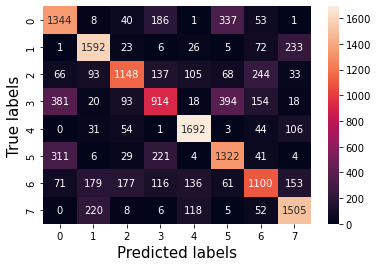

In [121]:
acc = accuracy_score(y_test_pred,y_test1)
confmat = confusion_matrix(y_test1, y_test_pred)

print("Accuracy:", acc)
# plot the confusion matrix
ax = plt.subplot()
sns.heatmap(confmat,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
plt.show()